In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import libpysal
# note that for pysal we need numpy<=2.0.0
from esda import Moran, Moran_Local
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import lines as mline

In [3]:
def clean_dataframe(df:pd.DataFrame, drop_rate: float=0.5, verbose: bool = True) -> pd.DataFrame:
    if drop_rate < 0 or drop_rate > 1:
        raise ValueError('drop_rate must be between 0 and 1')
    shape = df.shape
    df = df[df.columns[df.isna().sum() / df.shape[0] <= drop_rate]]
    df = df[df.columns[df.nunique() != 1]]
    df.drop_duplicates(inplace=True)
    if verbose:
        print(f'Cleaned DataFrame shape: {df.shape}')
        print(f'{shape[0] - df.shape[0]} rows were dropped')
        print(f'{shape[1] - df.shape[1]} columns were dropped')
    return df

In [4]:
df_kenya_birds1_raw = pd.read_csv('./data/simple/simple.csv', sep='\t', dtype={'infraspecificEpithet': str})
# The last dtype is to avoid the warning: "DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False."
df_kenya_birds1 = clean_dataframe(df_kenya_birds1_raw)
print(df_kenya_birds1.columns)
df_kenya_birds1

Cleaned DataFrame shape: (89632, 20)
0 rows were dropped
30 columns were dropped
Index(['gbifID', 'occurrenceID', 'order', 'family', 'genus', 'species',
       'taxonRank', 'scientificName', 'verbatimScientificName',
       'individualCount', 'decimalLatitude', 'decimalLongitude', 'eventDate',
       'day', 'month', 'year', 'taxonKey', 'speciesKey', 'lastInterpreted',
       'issue'],
      dtype='object')


,gbifID,occurrenceID,order,family,genus,species,taxonRank,scientificName,verbatimScientificName,individualCount,decimalLatitude,decimalLongitude,eventDate,day,month,year,taxonKey,speciesKey,lastInterpreted,issue
0,1986821111,d33e1483-ad6a-4aa2-95bd-5d4568a3cd3b,Passeriformes,Zosteropidae,Zosterops,Zosterops silvanus,SPECIES,"Zosterops silvanus J.L.Peters & Loveridge, 1935",Zosterops silvanus,1.0,-3.432285,38.341012,2017-11-09,9,11,2017,6100772,6100772.0,2024-03-21T12:54:52.894Z,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...
1,1986821110,d12a2b54-f12a-40a7-bfb5-90b4998af7d3,Passeriformes,Zosteropidae,Zosterops,Zosterops senegalensis,SPECIES,"Zosterops senegalensis Bonaparte, 1850",Zosterops senegalensis,1.0,0.206000,34.884667,2017-06-01,1,6,2017,2489344,2489344.0,2024-03-21T12:54:54.972Z,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...
2,1986821109,ff92601a-f8b9-4db0-90a1-e4d0b233ace0,Passeriformes,Zosteropidae,Zosterops,Zosterops senegalensis,SPECIES,"Zosterops senegalensis Bonaparte, 1850",Zosterops senegalensis,4.0,-0.558500,36.523667,2017-06-01,1,6,2017,2489344,2489344.0,2024-03-21T12:54:57.153Z,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...
3,1986821108,a6bf4a1c-5c59-4a23-a18a-4ca9e6c36342,Passeriformes,Zosteropidae,Zosterops,Zosterops silvanus,SPECIES,"Zosterops silvanus J.L.Peters & Loveridge, 1935",Zosterops silvanus,1.0,-3.399601,38.329516,2017-10-06,6,10,2017,6100772,6100772.0,2024-03-21T12:55:11.136Z,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...
4,1986821107,215c7fe0-9e39-4497-86b5-87532c478ef8,Passeriformes,Zosteropidae,Zosterops,Zosterops silvanus,SPECIES,"Zosterops silvanus J.L.Peters & Loveridge, 1935",Zosterops silvanus,1.0,-3.380438,38.353286,2017-10-06,6,10,2017,6100772,6100772.0,2024-03-21T12:54:51.116Z,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89627,1986731294,e49afe06-1ab4-410e-8971-186b5967b86b,Accipitriformes,Accipitridae,Accipiter,Accipiter badius,SPECIES,"Accipiter badius (Gmelin, 1788)",Accipiter badius,1.0,1.114823,37.460524,2018-01-13,13,1,2018,2480610,2480610.0,2024-03-21T12:54:56.058Z,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...
89628,1986731293,82c2acec-5ed5-4b92-be62-2b43522a6f46,Accipitriformes,Accipitridae,Accipiter,Accipiter badius,SPECIES,"Accipiter badius (Gmelin, 1788)",Accipiter badius,1.0,1.010063,37.385208,2018-01-12,12,1,2018,2480610,2480610.0,2024-03-21T12:54:57.383Z,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...
89629,1986731292,5da4a7c3-c2b9-4865-81b8-fb1f620ff070,Accipitriformes,Accipitridae,Accipiter,Accipiter melanoleucus,SPECIES,"Accipiter melanoleucus A.Smith, 1830",Accipiter melanoleucus,1.0,-3.991421,39.692136,2018-01-29,29,1,2018,2480631,2480631.0,2024-03-21T12:55:12.203Z,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...
89630,1986731291,0d16b63d-2c88-43df-a45d-27c19f6e566c,Accipitriformes,Accipitridae,Accipiter,Accipiter badius,SPECIES,"Accipiter badius (Gmelin, 1788)",Accipiter badius,1.0,-3.415807,38.650147,2018-02-01,1,2,2018,2480610,2480610.0,2024-03-21T12:54:53.528Z,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...


In [5]:
df_kenya_birds2_raw = pd.read_csv('./data/species list/species_list.csv', sep='\t')
df_kenya_birds2 = clean_dataframe(df_kenya_birds2_raw)
print(df_kenya_birds2.columns)
df_kenya_birds2

Cleaned DataFrame shape: (1256, 16)
0 rows were dropped
6 columns were dropped
Index(['taxonKey', 'scientificName', 'acceptedTaxonKey',
       'acceptedScientificName', 'numberOfOccurrences', 'taxonRank',
       'taxonomicStatus', 'order', 'orderKey', 'family', 'familyKey', 'genus',
       'genusKey', 'species', 'speciesKey', 'iucnRedListCategory'],
      dtype='object')


,taxonKey,scientificName,acceptedTaxonKey,acceptedScientificName,numberOfOccurrences,taxonRank,taxonomicStatus,order,orderKey,family,familyKey,genus,genusKey,species,speciesKey,iucnRedListCategory
0,2492478,"Cercotrichas galactotes (Temminck, 1820)",5788860,"Erythropygia galactotes (Temminck, 1820)",33,SPECIES,SYNONYM,Passeriformes,729,Muscicapidae,9322,Erythropygia,4845640,Erythropygia galactotes,5788860.0,LC
1,2493976,"Dicrurus modestus Hartlaub, 1849",2493976,"Dicrurus modestus Hartlaub, 1849",42,SPECIES,ACCEPTED,Passeriformes,729,Dicruridae,9310,Dicrurus,2493960,Dicrurus modestus,2493976.0,LC
2,2494070,"Ploceus melanocephalus (Linnaeus, 1758)",2494070,"Ploceus melanocephalus (Linnaeus, 1758)",86,SPECIES,ACCEPTED,Passeriformes,729,Ploceidae,9336,Ploceus,2494008,Ploceus melanocephalus,2494070.0,LC
3,5230043,"Nectarinia hunteri (Shelley, 1889)",7340862,"Chalcomitra hunteri (Shelley, 1889)",2,SPECIES,SYNONYM,Passeriformes,729,Nectariniidae,5259,Chalcomitra,7340859,Chalcomitra hunteri,7340862.0,LC
4,5231347,"Bradypterus lopezi (Alexander, 1903)",5231347,"Bradypterus lopezi (Alexander, 1903)",13,SPECIES,ACCEPTED,Passeriformes,729,Locustellidae,6100825,Bradypterus,3242162,Bradypterus lopezi,5231347.0,LC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251,2478792,"Stactolaema olivacea (Shelley, 1880)",2478792,"Stactolaema olivacea (Shelley, 1880)",31,SPECIES,ACCEPTED,Piciformes,724,Lybiidae,4849497,Stactolaema,2478791,Stactolaema olivacea,2478792.0,LC
1252,2484628,"Vidua macroura (Pallas, 1764)",2484628,"Vidua macroura (Pallas, 1764)",239,SPECIES,ACCEPTED,Passeriformes,729,Viduidae,5295,Vidua,2484612,Vidua macroura,2484628.0,LC
1253,2493594,"Lonchura fringilloides (Lafresnaye, 1835)",2493594,"Lonchura fringilloides (Lafresnaye, 1835)",2,SPECIES,ACCEPTED,Passeriformes,729,Estrildidae,5709,Lonchura,2493593,Lonchura fringilloides,2493594.0,LC
1254,5231303,"Sylvia lugens Rüppell, 1840",5231303,"Sylvia lugens Rüppell, 1840",65,SPECIES,ACCEPTED,Passeriformes,729,Sylviidae,5285,Sylvia,2492941,Sylvia lugens,5231303.0,LC


In [6]:
df_occurance_raw = pd.read_csv('./data/darwin core archive/occurrence.txt', sep='\t', dtype={'infraspecificEpithet': str})
# The last dtype is to avoid the warning: "DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False."
df_occurance = clean_dataframe(df_occurance_raw)
print(df_occurance.columns)
df_occurance

Cleaned DataFrame shape: (89632, 42)
0 rows were dropped
181 columns were dropped
Index(['gbifID', 'occurrenceID', 'individualCount', 'occurrenceRemarks',
       'eventDate', 'startDayOfYear', 'endDayOfYear', 'year', 'month', 'day',
       'decimalLatitude', 'decimalLongitude', 'scientificName', 'order',
       'family', 'genus', 'genericName', 'specificEpithet', 'taxonRank',
       'vernacularName', 'taxonomicStatus', 'lastInterpreted', 'issue',
       'taxonKey', 'acceptedTaxonKey', 'orderKey', 'familyKey', 'genusKey',
       'speciesKey', 'species', 'acceptedScientificName',
       'verbatimScientificName', 'lastParsed', 'level0Gid', 'level0Name',
       'level1Gid', 'level1Name', 'level2Gid', 'level2Name', 'level3Gid',
       'level3Name', 'iucnRedListCategory'],
      dtype='object')


,gbifID,occurrenceID,individualCount,occurrenceRemarks,eventDate,startDayOfYear,endDayOfYear,year,month,day,...,lastParsed,level0Gid,level0Name,level1Gid,level1Name,level2Gid,level2Name,level3Gid,level3Name,iucnRedListCategory
0,1986821111,d33e1483-ad6a-4aa2-95bd-5d4568a3cd3b,1.0,Endangered (EN),2017-11-09,313,313,2017,11,9,...,2024-03-21T12:54:52.894Z,KEN,Kenya,KEN.39_1,Taita Taveta,KEN.39.1_1,Mwatate,KEN.39.1.5_1,Wusi/Kishamba,EN
1,1986821110,d12a2b54-f12a-40a7-bfb5-90b4998af7d3,1.0,Least Concern (LC),2017-06-01,152,152,2017,6,1,...,2024-03-21T12:54:54.972Z,KEN,Kenya,KEN.11_1,Kakamega,KEN.11.11_1,Shinyalu,KEN.11.11.1_1,Isukha Central,LC
2,1986821109,ff92601a-f8b9-4db0-90a1-e4d0b233ace0,4.0,Least Concern (LC),2017-06-01,152,152,2017,6,1,...,2024-03-21T12:54:57.153Z,KEN,Kenya,KEN.35_1,Nyandarua,KEN.35.1_1,Kinangop,KEN.35.1.1_1,Engineer,LC
3,1986821108,a6bf4a1c-5c59-4a23-a18a-4ca9e6c36342,1.0,Endangered (EN),2017-10-06,279,279,2017,10,6,...,2024-03-21T12:55:11.136Z,KEN,Kenya,KEN.39_1,Taita Taveta,KEN.39.4_1,Wundanyi,KEN.39.4.4_1,Wundanyi/Mbale,EN
4,1986821107,215c7fe0-9e39-4497-86b5-87532c478ef8,1.0,Endangered (EN),2017-10-06,279,279,2017,10,6,...,2024-03-21T12:54:51.116Z,KEN,Kenya,KEN.39_1,Taita Taveta,KEN.39.4_1,Wundanyi,KEN.39.4.2_1,Werugha,EN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89627,1986731294,e49afe06-1ab4-410e-8971-186b5967b86b,1.0,Least Concern (LC),2018-01-13,13,13,2018,1,13,...,2024-03-21T12:54:56.058Z,KEN,Kenya,KEN.37_1,Samburu,KEN.37.1_1,Samburu East,KEN.37.1.1_1,Wamba East,LC
89628,1986731293,82c2acec-5ed5-4b92-be62-2b43522a6f46,1.0,Least Concern (LC),2018-01-12,12,12,2018,1,12,...,2024-03-21T12:54:57.383Z,KEN,Kenya,KEN.37_1,Samburu,KEN.37.1_1,Samburu East,KEN.37.1.1_1,Wamba East,LC
89629,1986731292,5da4a7c3-c2b9-4865-81b8-fb1f620ff070,1.0,Least Concern (LC),2018-01-29,29,29,2018,1,29,...,2024-03-21T12:55:12.203Z,KEN,Kenya,KEN.28_1,Mombasa,KEN.28.3_1,Kisauni,KEN.28.3.5_1,Mtopanga,LC
89630,1986731291,0d16b63d-2c88-43df-a45d-27c19f6e566c,1.0,Least Concern (LC),2018-02-01,32,32,2018,2,1,...,2024-03-21T12:54:53.528Z,KEN,Kenya,KEN.39_1,Taita Taveta,KEN.39.3_1,Voi,KEN.39.3.1_1,Kaloleni,LC


In [7]:
verbatim_raw = pd.read_csv('./data/darwin core archive/verbatim.txt', sep='\t')
verbatim = clean_dataframe(verbatim_raw)
print(verbatim.columns)
verbatim

Cleaned DataFrame shape: (89632, 14)
0 rows were dropped
176 columns were dropped
Index(['gbifID', 'occurrenceID', 'individualCount', 'occurrenceRemarks',
       'eventDate', 'decimalLatitude', 'decimalLongitude', 'scientificName',
       'class', 'order', 'family', 'genus', 'specificEpithet',
       'vernacularName'],
      dtype='object')


,gbifID,occurrenceID,individualCount,occurrenceRemarks,eventDate,decimalLatitude,decimalLongitude,scientificName,class,order,family,genus,specificEpithet,vernacularName
0,1986821111,d33e1483-ad6a-4aa2-95bd-5d4568a3cd3b,1.0,Endangered (EN),2017-11-09,-3.432285,38.341012,Zosterops silvanus,Aves,Passeriformes,Zosteropidae,Zosterops,silvanus,Taita White-eye
1,1986821110,d12a2b54-f12a-40a7-bfb5-90b4998af7d3,1.0,Least Concern (LC),2017-06-01,0.206000,34.884667,Zosterops senegalensis,Aves,Passeriformes,Zosteropidae,Zosterops,senegalensis,African Yellow White-eye
2,1986821109,ff92601a-f8b9-4db0-90a1-e4d0b233ace0,4.0,Least Concern (LC),2017-06-01,-0.558500,36.523667,Zosterops senegalensis,Aves,Passeriformes,Zosteropidae,Zosterops,senegalensis,African Yellow White-eye
3,1986821108,a6bf4a1c-5c59-4a23-a18a-4ca9e6c36342,1.0,Endangered (EN),2017-10-06,-3.399601,38.329516,Zosterops silvanus,Aves,Passeriformes,Zosteropidae,Zosterops,silvanus,Taita White-eye
4,1986821107,215c7fe0-9e39-4497-86b5-87532c478ef8,1.0,Endangered (EN),2017-10-06,-3.380438,38.353286,Zosterops silvanus,Aves,Passeriformes,Zosteropidae,Zosterops,silvanus,Taita White-eye
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89627,1986731294,e49afe06-1ab4-410e-8971-186b5967b86b,1.0,Least Concern (LC),2018-01-13,1.114823,37.460524,Accipiter badius,Aves,Accipitriformes,Accipitridae,Accipiter,badius,Shikra
89628,1986731293,82c2acec-5ed5-4b92-be62-2b43522a6f46,1.0,Least Concern (LC),2018-01-12,1.010063,37.385208,Accipiter badius,Aves,Accipitriformes,Accipitridae,Accipiter,badius,Shikra
89629,1986731292,5da4a7c3-c2b9-4865-81b8-fb1f620ff070,1.0,Least Concern (LC),2018-01-29,-3.991421,39.692136,Accipiter melanoleucus,Aves,Accipitriformes,Accipitridae,Accipiter,melanoleucus,Black Sparrowhawk
89630,1986731291,0d16b63d-2c88-43df-a45d-27c19f6e566c,1.0,Least Concern (LC),2018-02-01,-3.415807,38.650147,Accipiter badius,Aves,Accipitriformes,Accipitridae,Accipiter,badius,Shikra


In [8]:
df = df_kenya_birds1[['order', 'decimalLongitude', 'decimalLatitude', 'individualCount']].copy()
print(df.isna().sum())
df = df.dropna().reset_index(drop=True)
df['order'].value_counts()

order                0
decimalLongitude     0
decimalLatitude      0
individualCount     80
dtype: int64


order
Passeriformes          49872
Pelecaniformes          5545
Accipitriformes         5439
Columbiformes           4943
Charadriiformes         3953
Coraciiformes           3111
Piciformes              2860
Bucerotiformes          1749
Coliiformes             1585
Cuculiformes            1426
Apodiformes             1361
Anseriformes            1261
Galliformes             1169
Ciconiiformes           1097
Gruiformes               852
Musophagiformes          741
Suliformes               485
Falconiformes            320
Otidiformes              318
Psittaciformes           312
Strigiformes             223
Podicipediformes         211
Caprimulgiformes         208
Phoenicopteriformes      145
Struthioniformes         145
Pteroclidiformes         124
Trogoniformes             92
Procellariiformes          5
Name: count, dtype: int64

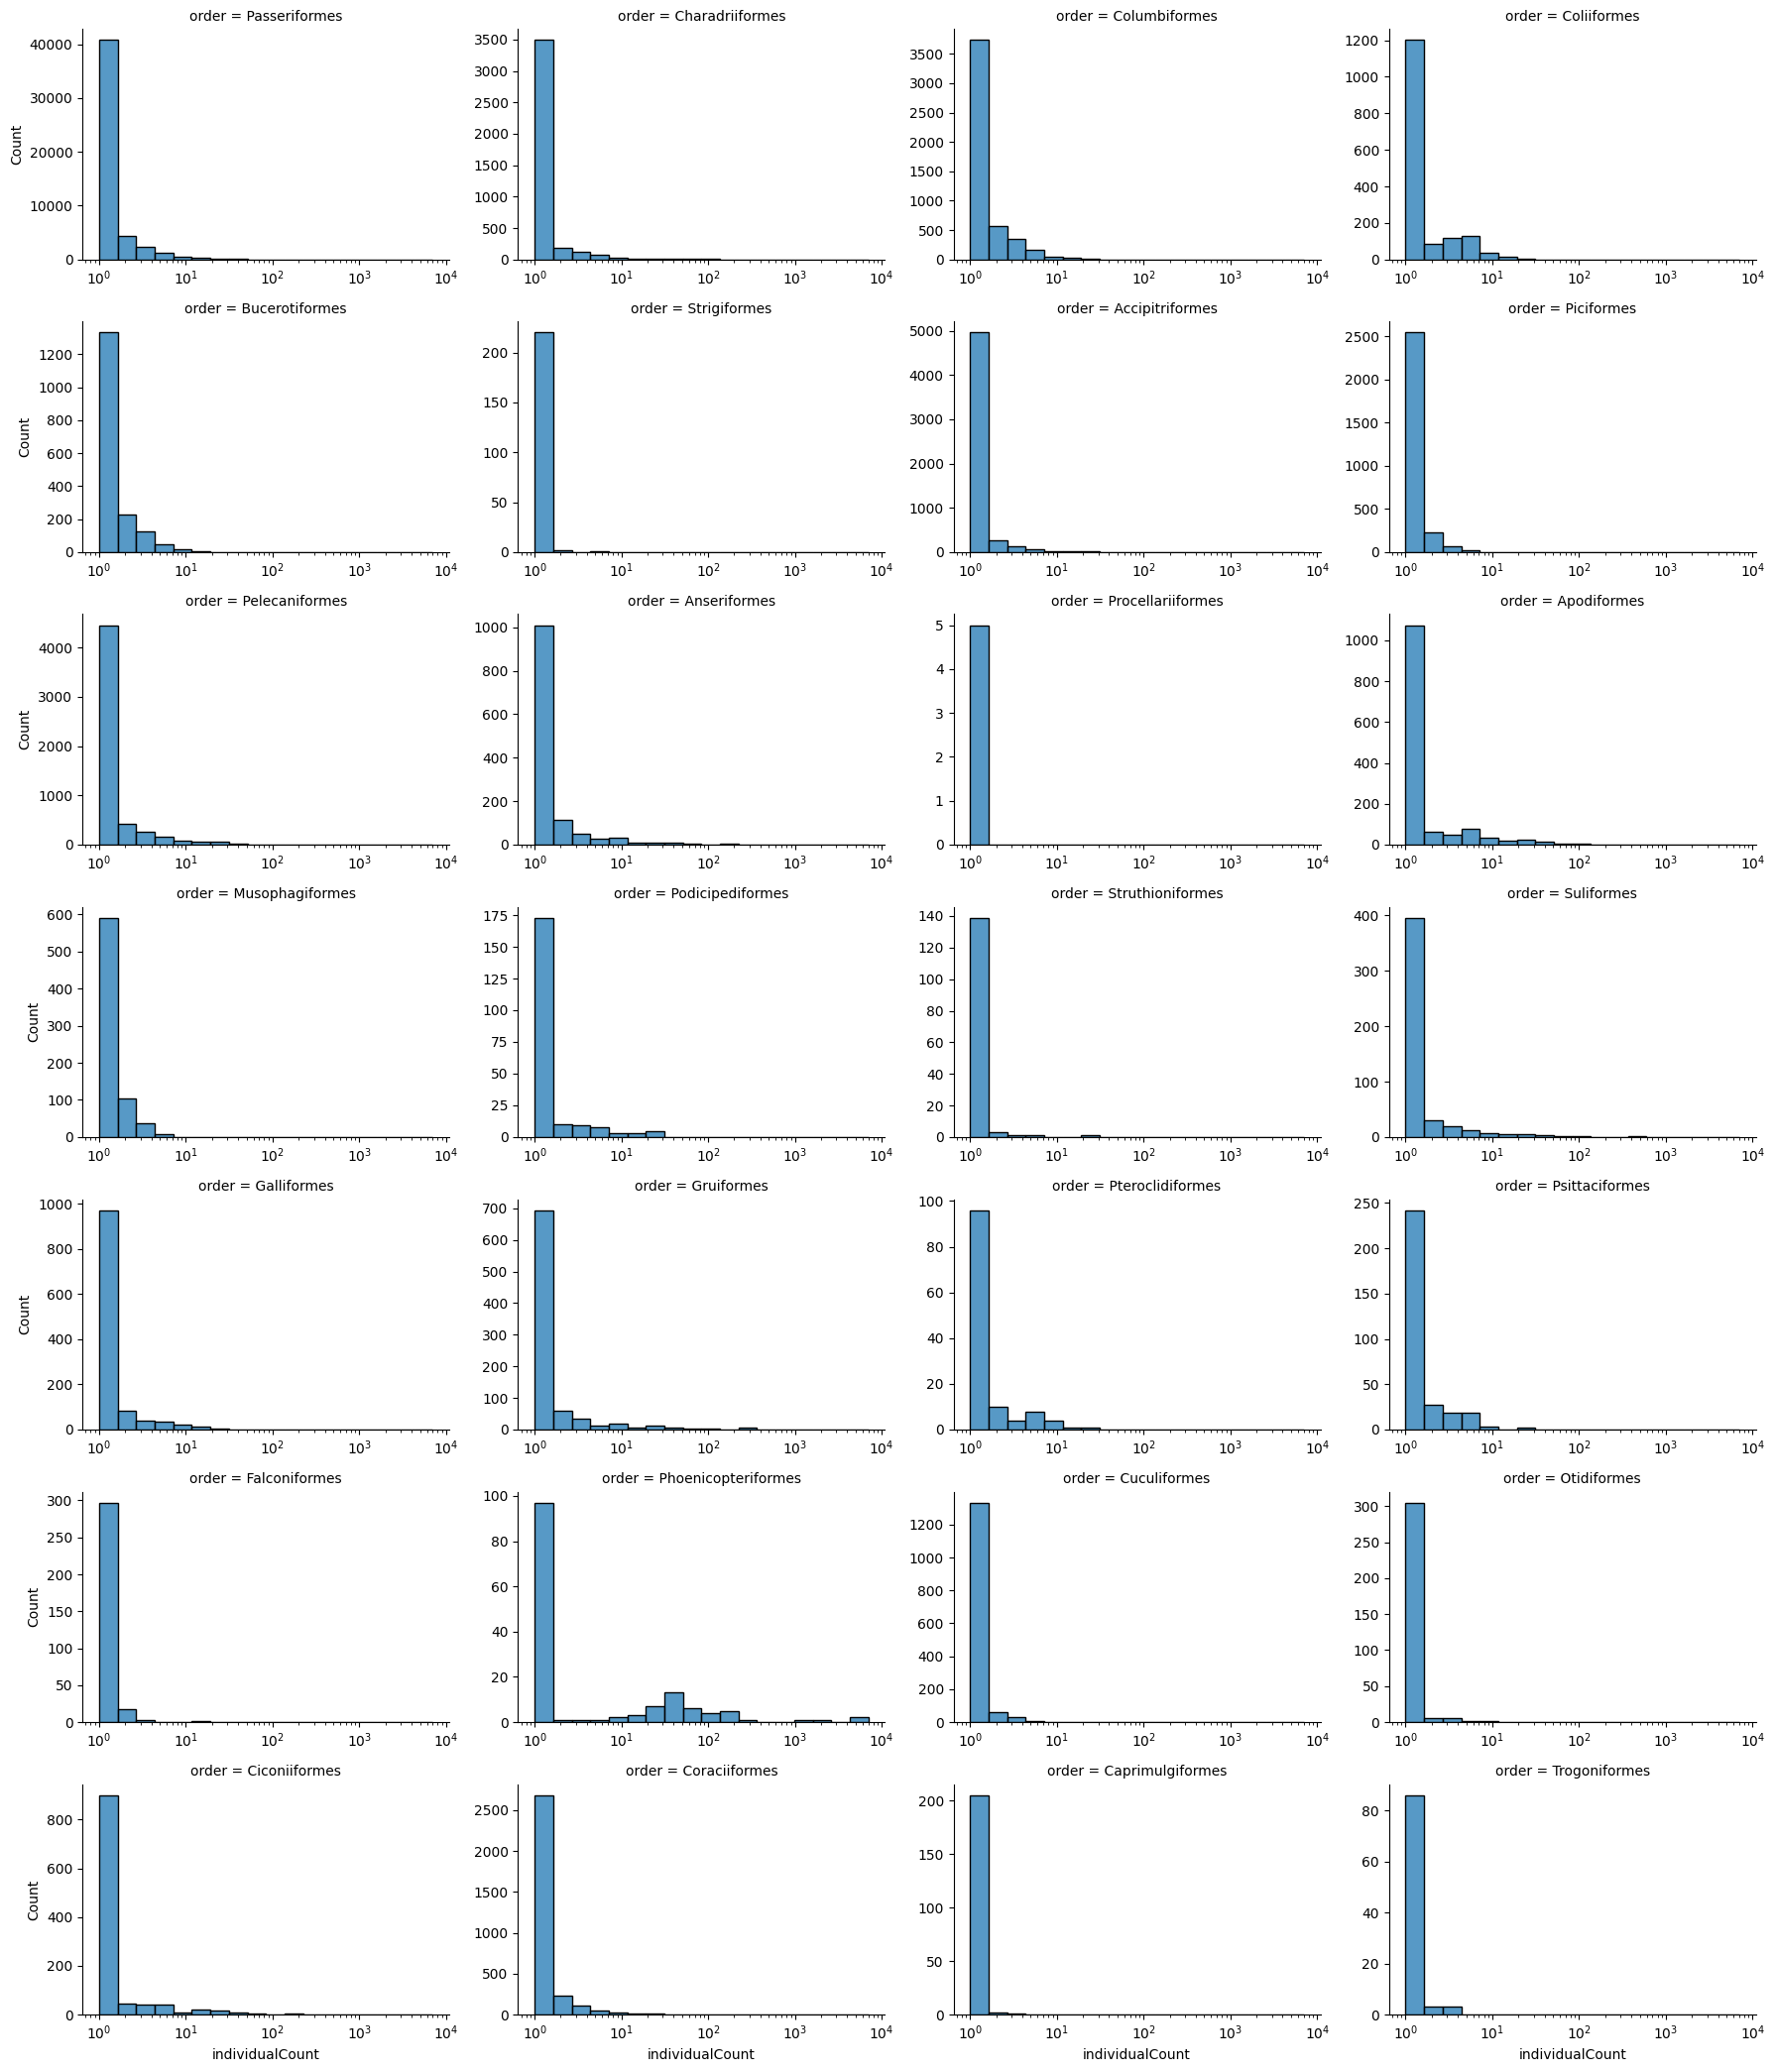

In [9]:
sns.displot(
    df,
    x="individualCount",
    log_scale=(True, False),
    col="order",
    col_wrap=4,
    facet_kws=dict(sharey=False, sharex=False),
    height=3,
    aspect=1.5,
)
plt.show()

In [10]:
min_lan = df['decimalLatitude'].min()
max_lan = df['decimalLatitude'].max()
min_lon = df['decimalLongitude'].min()
max_lon = df['decimalLongitude'].max()

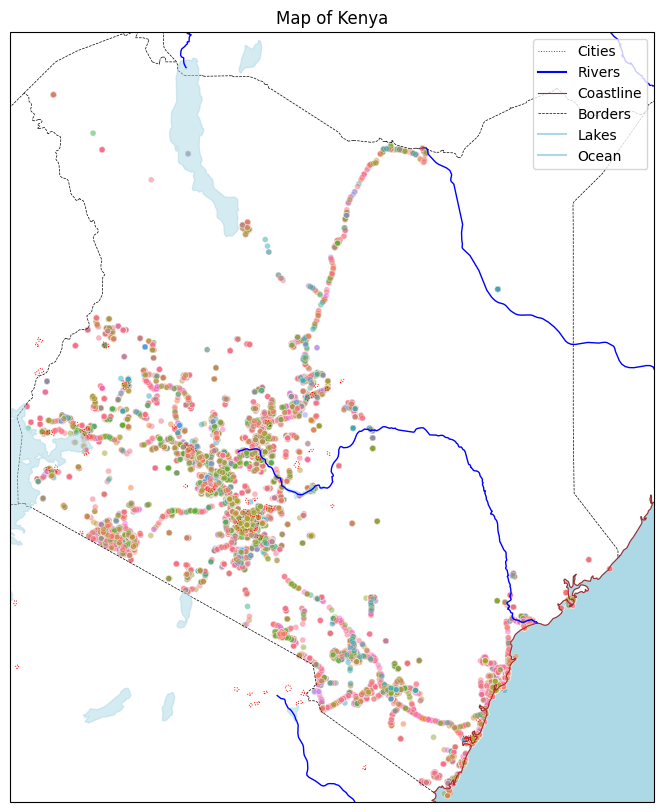

In [11]:
def draw_kenya(ax=None, legend=True):
    if ax is None:
        fig, ax = plt.subplots(
            subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(10, 10)
        )

    ax.set_extent([33.8, 42, -4.8, 5])  # [lon_min, lon_max, lat_min, lat_max]
    ax.add_feature(cfeature.COASTLINE, edgecolor="brown", linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle="--", linewidth=0.5)
    ax.add_feature(cfeature.LAKES, color="lightblue", alpha=0.5)
    ax.add_feature(cfeature.RIVERS, edgecolor="blue")
    ax.add_feature(cfeature.OCEAN, color="lightblue")

    ax.add_feature(
        cfeature.NaturalEarthFeature(
            "cultural",
            "urban_areas",
            "10m",
            edgecolor="red",
            facecolor="none",
            linewidth=0.7,
            linestyle=":",
        ),
        label="Cities",
    )

    # ax.legend(
    #     t := [
    #         mline.Line2D([], [], color=i.get_edgecolor(), linewidth=i.get_linewidth(), linestyle=i.get_linestyles()[0], label=i.get_label(), alpha=i.get_alpha())
    #         for i in [coastline, border, lakes, cities, river, ocean]
    #     ],
    #     [i.get_label() for i in [coastline, border, lakes, cities, river, ocean]],
    # )
    if legend:
        ax.legend(
            [
                mline.Line2D(
                    [], [], color="red", linestyle=":", linewidth=0.7, label="Cities"
                ),
                mline.Line2D([], [], color="blue", label="Rivers"),
                mline.Line2D([], [], color="brown", linewidth=0.8, label="Coastline"),
                mline.Line2D(
                    [],
                    [],
                    color="black",
                    linestyle="--",
                    linewidth=0.5,
                    label="Borders",
                ),
                mline.Line2D([], [], color="lightblue", label="Lakes"),
                mline.Line2D([], [], color="lightblue", label="Ocean"),
            ],
            ["Cities", "Rivers", "Coastline", "Borders", "Lakes", "Ocean"],
        )

    plt.title("Map of Kenya")
    return ax


ax = draw_kenya()
sns.scatterplot(
        data=df,
        x="decimalLongitude",
        y="decimalLatitude",
        hue="order",
        size="individualCount",
        # sizes=(10, 500),
        alpha=0.5,
        ax=ax,
        legend=False,
    )
plt.show()


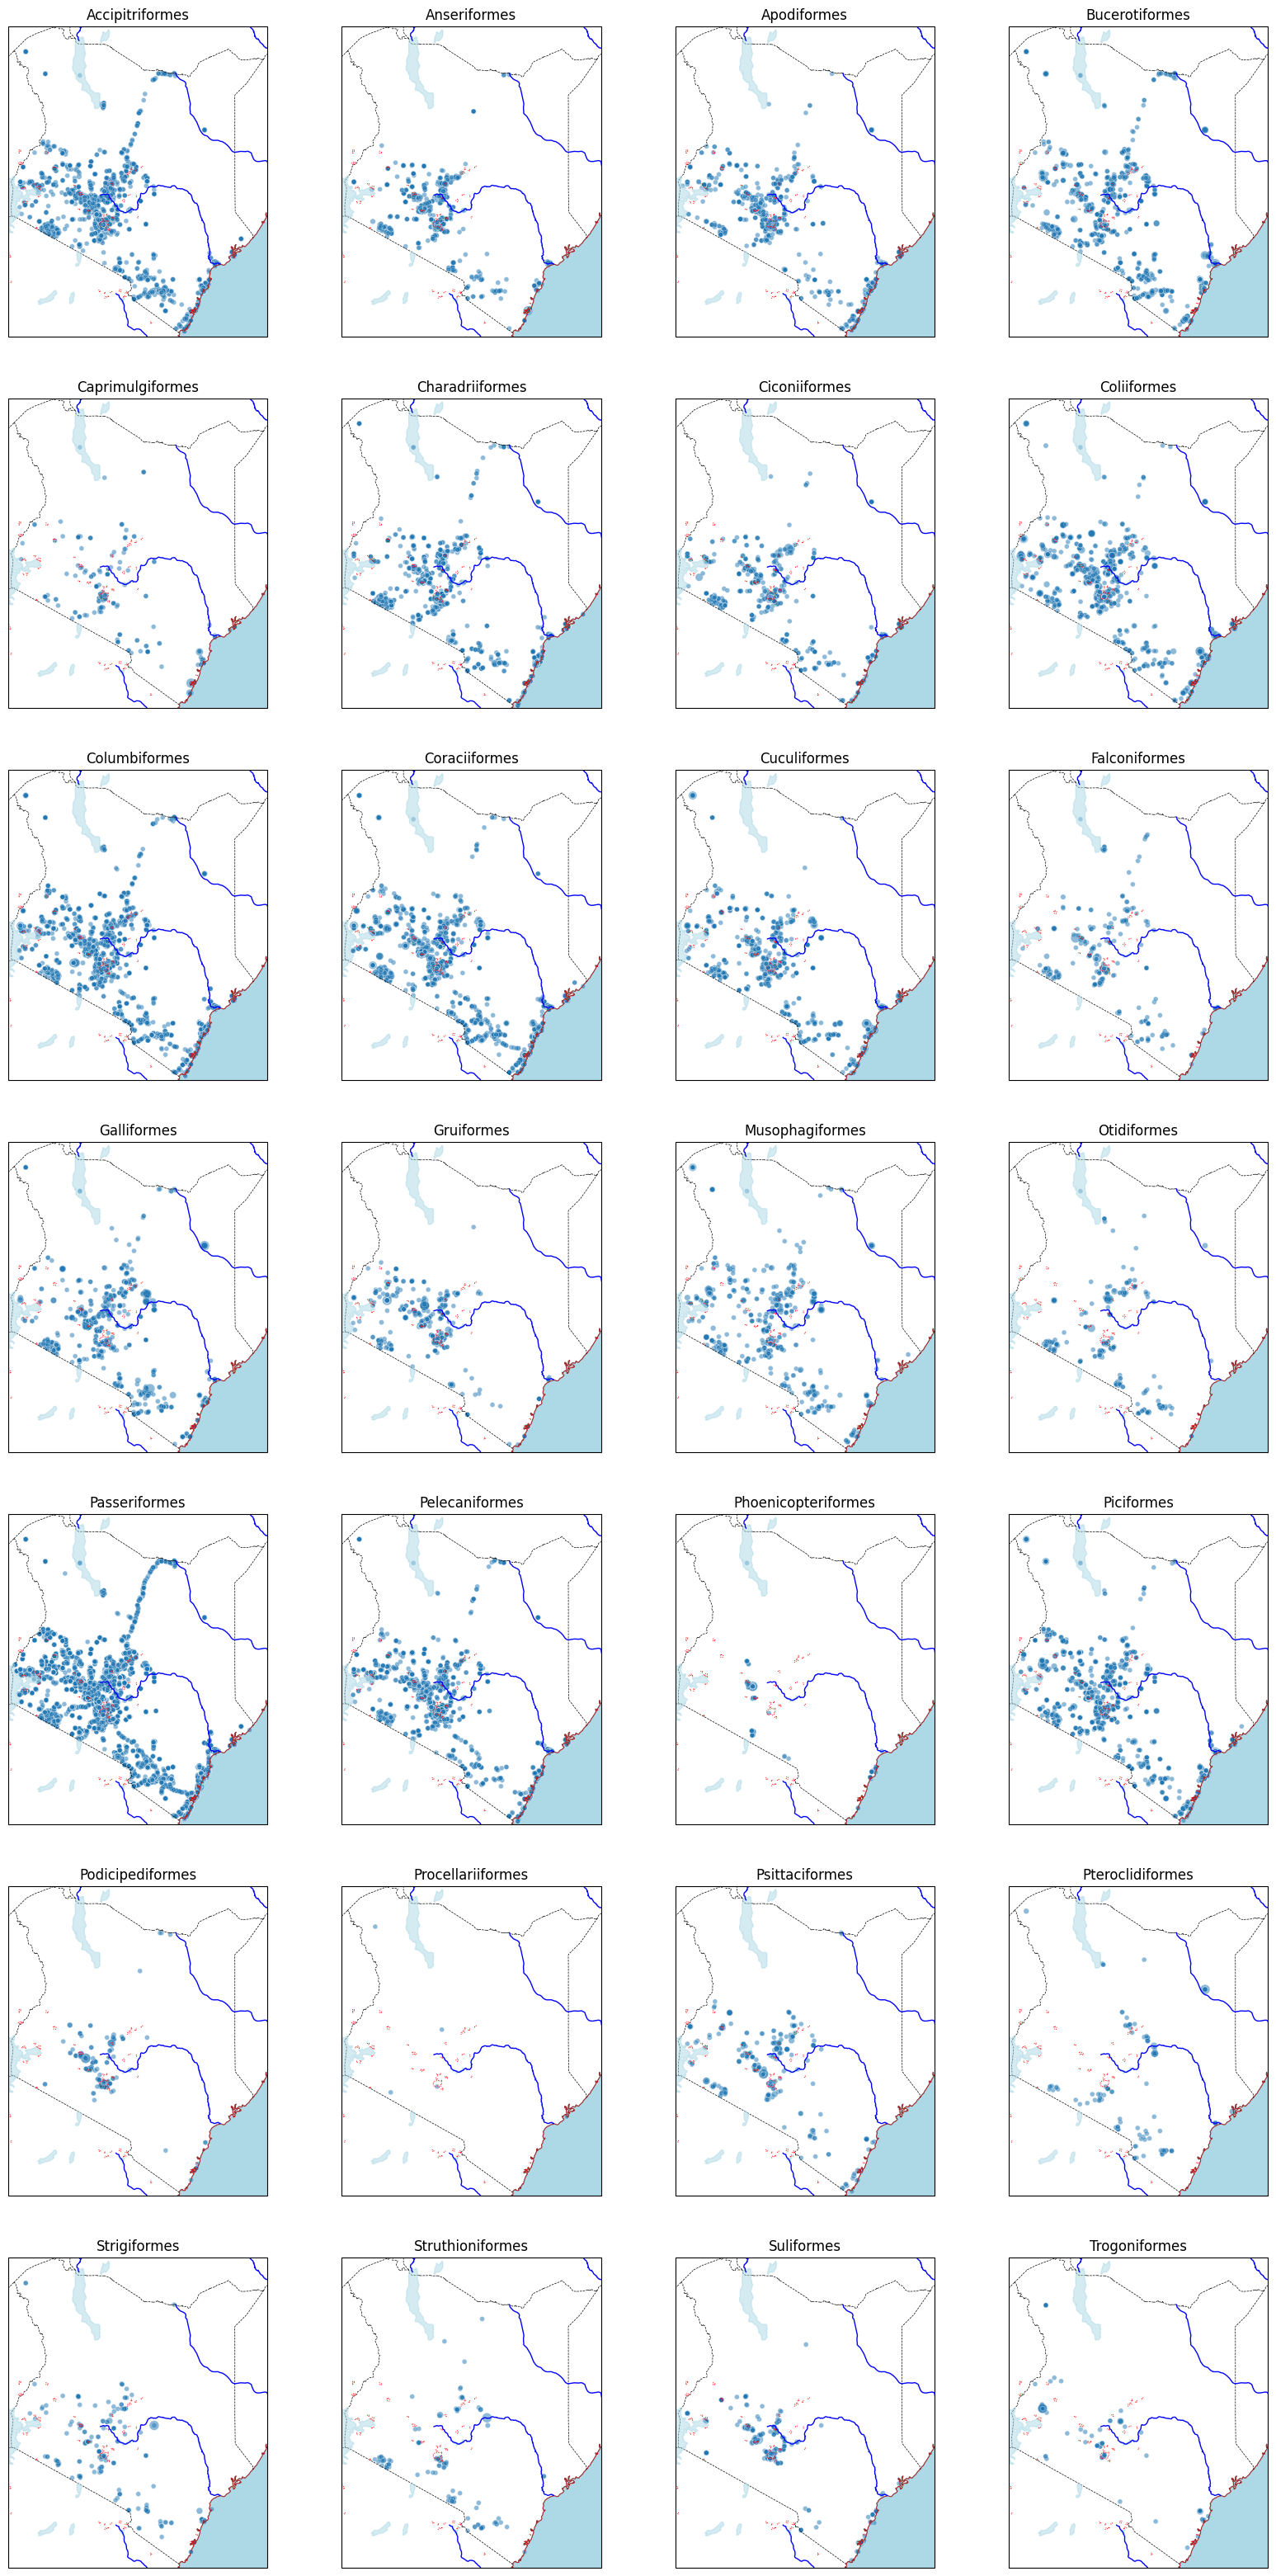

In [12]:
fig, axes = plt.subplots(7, 4, figsize=(20, 40), subplot_kw={"projection": ccrs.PlateCarree()})

for ax, (order, data) in zip(axes.ravel(), df.groupby("order")):
    assert data["order"].nunique() == 1, "Data must be grouped by order"
    draw_kenya(ax, legend=False)
    ax.set_title(order)
    sns.scatterplot(
        data=data,
        x="decimalLongitude",
        y="decimalLatitude",
        size="individualCount",
        alpha=0.5,
        ax=ax,
        legend=False,
    )

# plt.tight_layout()
plt.show()

## Moran's $\text{I}$ 
To calculate Moran's $\text{I}$, we need to calculate the spatial weights matrix to define the spatial relationships between observations in a dataset. This matrix identifies which observations are considered neighbors and how their influence is weighted, allowing us to quantify spatial dependencies. In the other words, this matrix is essential for measuring how similar or different values are across the space. Without it, spatial analyses cannot correctly account for the spatial arrangement of the data, leading to inaccurate assessments of spatial autocorrelation.

#### Threshold distance
Also, for calculating the weights matrix, we need to define a threshold distance to consider two observations as neighbors. If the threshold is too small, the matrix will be too sparse, and the spatial relationships will be poorly defined. On the other hand, if the threshold is too large, the matrix will be too dense, and the spatial relationships will be poorly estimated. Therefore, the threshold distance must be carefully chosen to ensure that the spatial relationships are accurately represented.

#### Avoid having single nodes (nodes with no neighbors)
Avoiding single nodes (observations with no neighbors) is crucial because they can distort spatial analysis results. Single nodes don't participate in calculations like Moran's $\text{I}$, leading to skewed or less reliable outcomes. They weaken the analysis by not reflecting real spatial interactions, making interpretations less meaningful. Ensuring each observation has neighbors helps keep the analysis accurate and insightful.

taking all of these into consideration, we can calculate Moran's $\text{I}$ as: We will try the threshold distance from function $t = \sqrt[3]{\frac{x}{3}}\qquad x\in\{1,2,\dots,39\}$, and we will stop at the first threshold that has no single nodes. if we cant find such threshold, we will use the threshold which has the minimum number of single nodes.

> Since this process is so much time and memory consuming, I have tried to save the results in a file at the end of each loop, and if we run the file again, the code will check if the file exists or not, and if it exists, it will load the results from the file instead of calculating them again.

> To run this part of the code, I have used ULHPC with around 150GB of RAM and 2 CPUs. The code is available in the `perform_moran.py` file. to run the code, you can use the following command:
> ```bash
>sbatch --time=02:00:00 -c 2 -N 2 -p batch --mem=150GB --wrap="python perform_moran.py"
>```

Finally we will have a dataframe with the following columns:
- threshold: the threshold distance used to calculate the Moran's $\text{I}$
- lonely_points: the number of single nodes in the dataset (we want to minimize this number, ideally 0)
- morans_I: the Moran's $\text{I}$ value
- morans_p_sim: the p-value of the Moran's $\text{I}$ value

Now, with these values in hand, we can analyze the spatial autocorrelation of the dataset and determine if the values are clustered, dispersed, or randomly distributed across space.

1. **Moran's I Value**:
   - **Positive Moran's I (> 0)**: Indicates positive spatial autocorrelation. This means the observations are clustered, suggesting that the species is frequently found near others of the same taxonomic order within specific regions.
   - **Negative Moran's I (< 0)**: Indicates negative spatial autocorrelation. This implies that the species are dispersed, meaning they tend to be found in isolation from others of the same order, spread more evenly across the country.
   - **Moran's I ≈ 0**: Suggests a random spatial distribution with no significant pattern of clustering or dispersion.

2. **P-value**:
   - The p-value helps determine the statistical significance of the Moran's I result.
   - **Low p-value (e.g., p < 0.05)**: Indicates that the observed spatial pattern is unlikely to have occurred by chance, making the spatial clustering or dispersion statistically significant.
   - **High p-value (e.g., p ≥ 0.05)**: Suggests that the observed spatial pattern is not significantly different from a random distribution, making any clustering or dispersion statistically uncertain.


In [31]:
morans = pd.read_csv('morans.csv', index_col=0).reset_index(names=['order'])
morans

,order,threshold,lonely_points,morans_I,morans_p_sim
0,Accipitriformes,1.954389,0.0,0.000580,0.058
1,Anseriformes,0.719223,0.0,-0.003545,0.151
2,Apodiformes,2.107436,0.0,-0.002964,0.009
3,Bucerotiformes,1.889059,0.0,0.031253,0.002
4,Caprimulgiformes,1.289416,0.0,0.034493,0.012
5,Charadriiformes,1.975072,0.0,-0.001583,0.003
6,Ciconiiformes,2.124830,0.0,-0.000158,0.168
7,Coliiformes,2.071607,0.0,0.027299,0.001
8,Columbiformes,1.954389,0.0,-0.001739,0.019
9,Coraciiformes,2.053136,0.0,0.003855,0.008


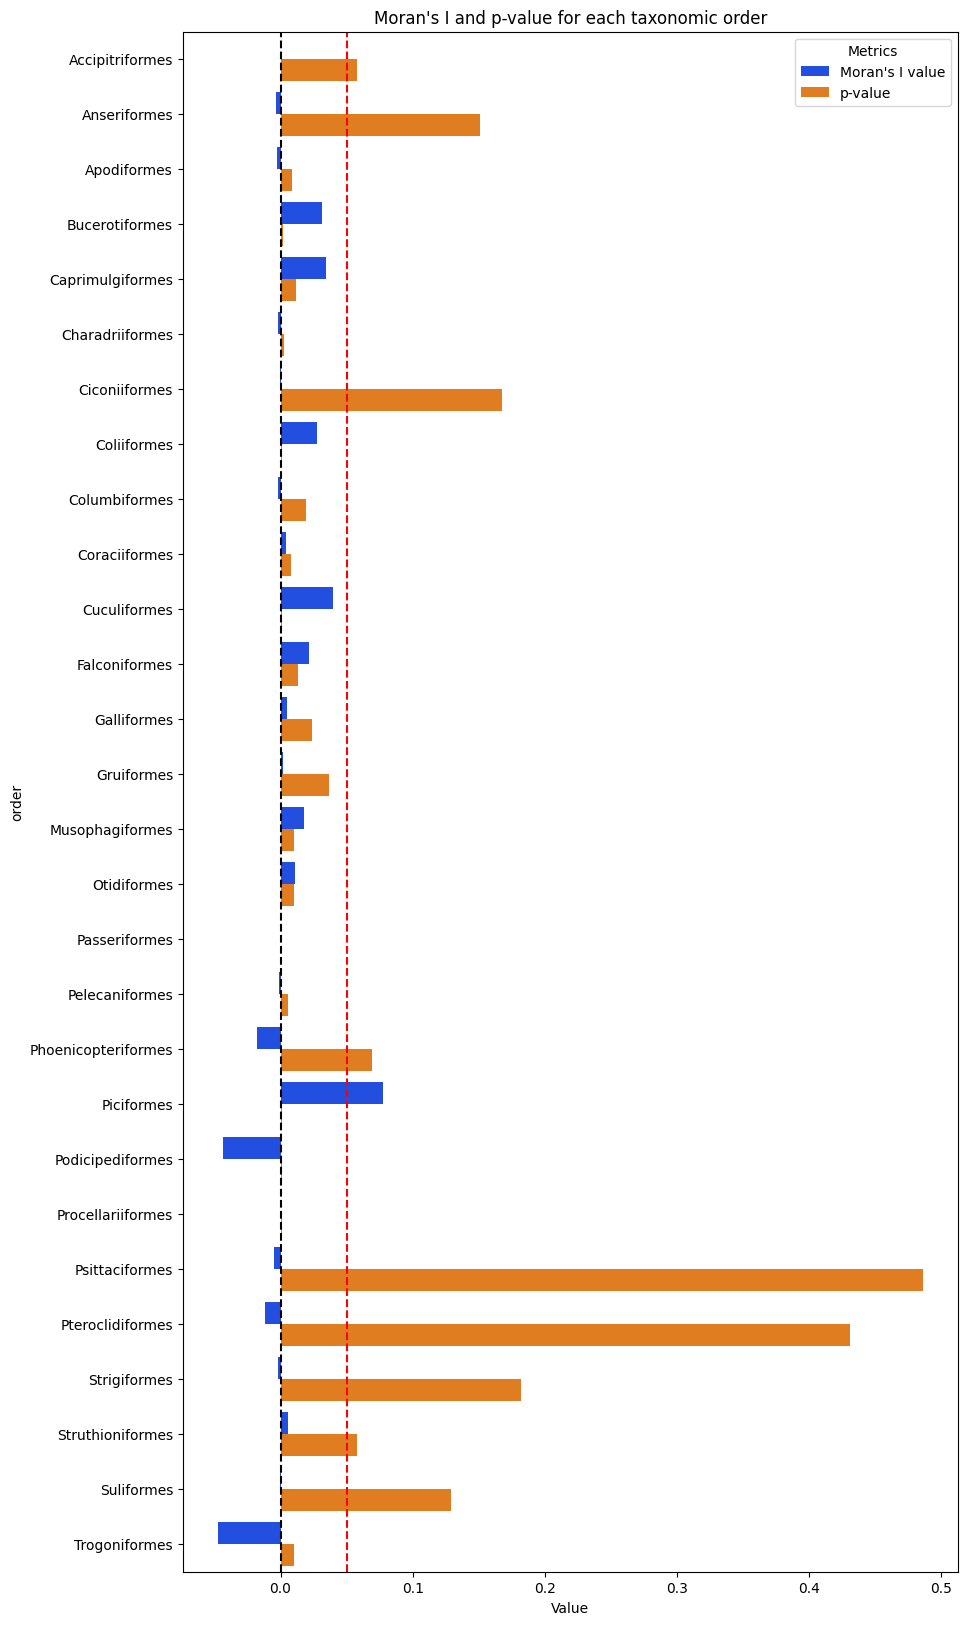

In [40]:
plt.figure(figsize=(10, 20))
sns.barplot(
    data=morans.rename(
        columns={"morans_I": (c1:=r"Moran's I value"), "morans_p_sim": (c2:="p-value")}
    ).melt(
        id_vars="order",
        value_vars=[c1, c2],
        var_name="Metrics",
        value_name="Value",
    ),
    y="order",
    x="Value",
    hue="Metrics",
    dodge=True,
    palette="bright",
    legend="full",
)

plt.axvline(0, color="black", linestyle="--")
plt.axvline(0.05, color="red", linestyle="--")
plt.title("Moran's I and p-value for each taxonomic order")
plt.xticks()
plt.show()

As we can see, none of the orders have a significant Moran's I value, which suggests that the spatial distribution of bird species across the country is not significantly clustered or dispersed. This indicates a more random distribution pattern, where the presence of bird species is not strongly influenced by the spatial arrangement of other species within the same taxonomic order.

To have a deeper analysis, lets say:

1. **Moran's I Interpretation**:
   - **Positive Moran's I Values**: Orders such as *Podicipediformes* and *Pelecaniformes* show positive Moran's I, indicating a clustering tendency where species from these groups are more likely to be found near each other.
   - **Negative or Near-Zero Moran's I**: Most orders, such as *Anseriformes*, *Falconiformes*, and *Gruiformes*, have Moran's I values near zero or slightly negative, suggesting a more dispersed or random distribution.

2. **P-value Significance**:
   - **Low p-values (< 0.05)**: Indicate significant spatial autocorrelation. For instance, *Podicipediformes* shows a Moran's I with a p-value below the 0.05 threshold (red dashed line), confirming significant clustering.
   - **High p-values (> 0.05)**: Most orders have p-values above 0.05, implying that their Moran's I values are not statistically significant and may reflect random distribution.

3. **Interpretation of Results**:
   - Taxonomic orders with a **significant positive Moran's I and a low p-value** exhibit spatial clustering, indicating that the species tend to be found together in specific regions.
   - Orders with **high p-values and Moran's I near zero** do not show strong evidence of clustering or dispersion patterns and are likely distributed randomly across the observed area.

The following orders MAY have a significant spatial autocorrelation (when the p-value is less than 0.05 or the Moran's I value is more than 0.5):

In [37]:
potential_cluster_orders = morans[np.logical_or(morans['morans_I'] > 0.5, morans['morans_p_sim'] < 0.05)]['order']
potential_cluster_orders

2           Apodiformes
3        Bucerotiformes
4      Caprimulgiformes
5       Charadriiformes
7           Coliiformes
8         Columbiformes
9         Coraciiformes
10         Cuculiformes
11        Falconiformes
12          Galliformes
13           Gruiformes
14      Musophagiformes
15          Otidiformes
17       Pelecaniformes
19           Piciformes
20     Podicipediformes
21    Procellariiformes
27        Trogoniformes
Name: order, dtype: object

## Hopkins Statistic

To support our analysis, we will also calculate the Hopkins statistic. This metric helps determine the clustering tendency of a dataset by measuring the probability that a given dataset is generated by a uniform distribution. The Hopkins statistic ranges from 0 to 1, with values closer to 1 indicating a high clustering tendency and values closer to 0 suggesting a random distribution. By calculating the Hopkins statistic, we can further assess the spatial distribution of the data and confirm the presence of spatial autocorrelation.

Again we have a parameter to consider, the number of random points to generate. we will try the number of random points from the set $\{i\times 50+10|i\in\{1,2,\dots,60\}\}$, and we will save all of them. Finally we will check min, max, and average of the Hopkins statistic for all of them.

In [38]:
from collections import defaultdict
from sklearn.neighbors import NearestNeighbors


def hopkins_statistic(X, n_samples=100):
    """
    Compute the Hopkins statistic for the given dataset.

    Parameters:
    - X: ndarray of shape (n_samples, n_features)
    - n_samples: Number of random points to sample

    Returns:
    - hopkins_stat: The Hopkins statistic value
    """
    n, d = X.shape
    if n_samples > n:
        n_samples = n  

    random_indices = np.random.choice(n, n_samples, replace=False)
    random_points = X[random_indices]

    min_vals = np.min(X, axis=0)
    max_vals = np.max(X, axis=0)
    uniform_points = np.random.uniform(min_vals, max_vals, (n_samples, d))

    nn = NearestNeighbors(n_neighbors=2)
    nn.fit(X)

    u_distances, _ = nn.kneighbors(uniform_points)
    u_distances = u_distances[:, 1]  # Exclude the point itself

    w_distances, _ = nn.kneighbors(random_points)
    w_distances = w_distances[:, 1]  # Exclude the point itself

    hopkins_stat = np.sum(w_distances) / (np.sum(w_distances) + np.sum(u_distances))
    return hopkins_stat


hopkins: dict[str, list[float]] = defaultdict(list)
for order, data in tqdm(df.groupby("order")):
    for n in range(10, 3000, 50):
        hopkins[order].append(hopkins_statistic(
            data[["decimalLongitude", "decimalLatitude"]].values,
            n_samples=n,
        ))

  0%|          | 0/28 [00:00<?, ?it/s]

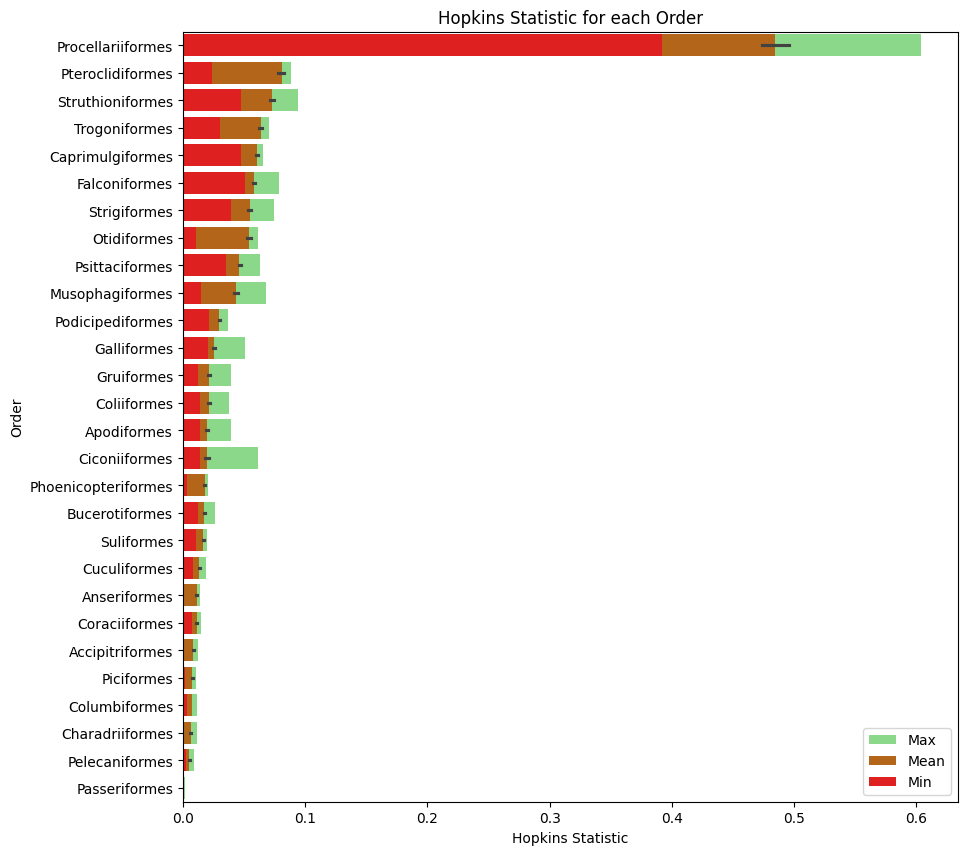

In [27]:

hdf = pd.DataFrame(hopkins)
hdf = hdf.sort_index(axis=1, key=lambda x: hdf[x].mean(), ascending=False)
plt.figure(figsize=(10, 10))

sns.barplot(
    data=hdf.max().reset_index(name="Hopkins Statistic"),
    y="index",
    x="Hopkins Statistic",
    legend="full",
    alpha=0.5,
    color=(0, 0.8, 0),
    label = 'Max'
)

sns.barplot(
    data=hdf.melt(
        var_name="Order",
        value_name="Hopkins Statistic",
    ),
    y="Order",
    x="Hopkins Statistic",
    color=(0.8, 0.4, 0),
    label = 'Mean'
)
sns.barplot(
    data=hdf.min().reset_index(name="Hopkins Statistic"),
    y="index",
    x="Hopkins Statistic",
    color=(1, 0, 0),
    label = 'Min'
)
plt.title("Hopkins Statistic for each Order")
plt.xlabel("Hopkins Statistic")
plt.ylabel("Order")
plt.show()

1. High Hopkins Values (Closer to 1):
   Orders such as Procellariiformes, Pteroclidiformes, and Struthioniformes exhibit higher Hopkins statistics, indicating a strong clustering tendency. These groups are more likely to have non-random, spatially clustered distributions.
2. Moderate to Low Hopkins Values:
   Orders like Charadriiformes, Pelecaniformes, and Passeriformes show lower Hopkins values, suggesting a tendency towards random or even distribution, with little to no significant clustering.